In [1]:
import torch
from datasets import Dataset, load_dataset
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.current_device())
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, RobertaTokenizerFast, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import random
path = '/app/Data/'
# model_path = 'google-bert/bert-base-uncased'
# tokenizer = BertTokenizerFast.from_pretrained(model_path)
model_path = 'FacebookAI/roberta-base'
tokenizer = RobertaTokenizerFast.from_pretrained(model_path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
NVIDIA GeForce RTX 3080
0


2024-04-12 09:44:49.302845: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 09:44:49.478080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 09:44:50.415644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [24]:
arrow_file_name = "data-00000-of-00001"
def load_data(path,tokenized=False):
    if tokenized:
        full_ds = load_dataset('arrow',data_files={
            'train_r':path+f'/tokenized/train_ds_r/{arrow_file_name}.arrow',
            'train_e':path+f'/tokenized/train_ds_e/{arrow_file_name}.arrow',
            'test':path+f'/tokenized/test_ds/{arrow_file_name}.arrow',
            'val':path+f'/tokenized/val_ds/{arrow_file_name}.arrow'
        })
    else:
        full_ds = load_dataset('arrow',data_files={
            'train_r':path+f'/train_ds_r/{arrow_file_name}.arrow',
            'train_e':path+f'/train_ds_e/{arrow_file_name}.arrow',
            'test':path+f'/test_ds/{arrow_file_name}.arrow',
            'validation':path+f'/val_ds/{arrow_file_name}.arrow'
        })
    return full_ds


### Train-Val-Test split, run only once

In [3]:
def shorten(text):
    words = text.split(" ")
    curr = None
    final = []
    for word in words:
        if word != curr:
            final.append(word)
        curr = word
    return " ".join(final)

def preprocess_function(id,example):
    text = example['processed']
    text = shorten(text)
    label = example['class']
    tokens = tokenizer.encode(text)
    cls_token = tokens[0]
    sep_token = tokens[-1]
    first_chunk = tokens[1: 511]
    c = []
    c.append(cls_token)
    c.extend(first_chunk)
    c.append(sep_token)
    return([c, label, id])

def preprocess(df):
    new_df = {'text':[],'label':[],'raw_text':[]}
    ids = []
    mapping = {"ham":0,"spam":1}
    for i,row in tqdm(df.iterrows()):
        new_df["raw_text"].append(" ".join(row['processed'].split(" ")[:512]))
        tokens, label, idx = preprocess_function(i,row)
        new_df['text'].append(tokens)
        new_df['label'].append(mapping[label])
        ids.append(idx)
    final_df = pd.DataFrame(new_df,index=ids)
    return final_df

In [6]:
seed = random.seed(37)
df = pd.read_pickle("/app/Data/full_df.pkl")
df = df.drop_duplicates(subset=['processed'])
X = df['processed']
y = df['class']
# Split into 70%: train, 20%: validation, 10% test
X_train, X_tr, y_train, y_tr = train_test_split(X,y,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_tr,y_tr,test_size=0.33)
train_df = pd.DataFrame({'processed':X_train,'class':y_train})
val_df = pd.DataFrame({'processed':X_val,'class':y_val})
test_df = pd.DataFrame({'processed':X_test,'class':y_test})
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 512). Running this sequence through the model will result in indexing errors
28523it [00:37, 757.38it/s] 
8190it [00:09, 825.28it/s] 
4035it [00:05, 674.83it/s]


# Data Augmentation with NLPAug

In [7]:
# Before preprocessing training data, first do data augmentation with nlpaug (Roberta does not work, memory does not clear every batch)
import nlpaug.augmenter.word as naw
train_texts_spam = train_df[train_df["label"]==1].raw_text
ins_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert", device="cuda", aug_p=0.05
)
ins_text = ins_aug.augment(list(train_texts_spam))
del ins_aug
sub_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute", device="cuda", aug_p=0.05
)
aug_texts = sub_aug.augment(ins_text)
del sub_aug

# Embedding Sampling

## Getting Sentence Embedding using mpnet

In [8]:
sentences = list(df.processed)
ids = df.index
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=torch.cuda.current_device())

In [9]:
embeddings = model.encode(sentences)
embedding_df = pd.DataFrame({"embedding": [embeddings[i] for i in range(len(ids))]}, index=list(ids))
embedding_df.to_pickle("/app/Data/embedding.pkl")

In [10]:
aug_embeddings = model.encode(aug_texts)
aug_spam = pd.DataFrame({"processed": aug_texts, 'class': "spam"})
aug_spam = preprocess(aug_spam)
aug_spam["embedding"] = [aug_embeddings[i] for i in range(len(aug_texts))]

6928it [00:04, 1529.54it/s]


In [11]:
# Clearing GPU VRAM
del model
torch.cuda.empty_cache()

In [12]:
embedding_df = pd.read_pickle("/app/Data/embedding.pkl")

## Defining Embedding Sampler

In [13]:
import jax
import jax.numpy as jnp
if torch.cuda.is_available():
    jax_device = jax.devices("gpu")[0]
else:
    jax_device = jax.devices("cpu")[0]

I0000 00:00:1712916626.103382   14080 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [14]:
def cosine_sim(x,y):
    '''
    Computes cosine similarity between b and each row of a
    x: 2d np vector
    y: 1d np vector
    '''
    dot_product = jnp.dot(x, y)
    
    # Compute the magnitudes of x and y
    x_norm = jnp.linalg.norm(x, axis=1)
    y_norm = jnp.linalg.norm(y)
    
    # Compute the cosine similarity
    similarity = dot_product / (x_norm * y_norm)
    
    return similarity
cosine_sim_jit = jax.jit(device=jax_device, fun=cosine_sim)

In [15]:
class Post(object):
    def __init__(self, embedding, pos):
        self.embedding = embedding
        self.closest_dst = -1 # Cosine similarity is a value from -1 to 1, with similar posts having value close to 1
        self.pos = pos # Position in self.posts

    def __lt__(self, other):
        return self.closest_dst < other.closest_dst

class Undersample:
    def __init__(self, df):
        self.df = df
        self.post_ids = list(df.index)
        self.distances = jnp.array([-1] * len(self.post_ids))
        self.embeddings = np.row_stack(list(df.embedding))
        self.embeddings = jax.device_put(jnp.array(self.embeddings), device=jax_device)
        self.selected_ids = []
        self.recent = None
        self.furthest = -1
        self.logfile = "/app/log.txt"
        with open(self.logfile, "w") as f:
            pass
    
    def select_furthest(self):
        if len(self.selected_ids) == 0:
            # Pick random starting point
            recent_pos = random.randint(0, len(self.post_ids)-1)
            self.selected_ids.append(self.post_ids[recent_pos])
            self.recent = self.embeddings[recent_pos]
            return 
        dist_to_recent = cosine_sim_jit(self.embeddings, self.recent)
        self.distances = jnp.maximum(self.distances, dist_to_recent)
        recent_pos = jnp.argmin(self.distances)
        self.furthest = jnp.min(self.distances)
        with open(self.logfile, "a") as f:
            #f.write(f"{dist_to_recent} \n")
            f.write(f"{self.furthest} \n")
            #f.write(f"{self.distances} \n")
        self.selected_ids.append(self.post_ids[recent_pos])
        self.recent = self.embeddings[recent_pos]
        return

    def select_n(self, n):
        if n>len(self.post_ids):
            return self.df
        for i in tqdm(range(n)):
            self.select_furthest()
        print(f"Furthest{self.furthest}")
        return self.df[self.df.index.isin(self.selected_ids)]
    
    def select_threshold(self,threshold):
        while self.furthest < threshold:
            self.select_furthest()
        return self.df[self.df.index.isin(self.selected_ids)]    

## Undersampling

In [16]:
train_spam = train_df[train_df.label==1].copy()
train_ham = train_df[train_df.label==0].copy()
train_ham_embed = pd.merge(train_ham, embedding_df, left_index=True, right_index=True)
train_spam_embed = pd.merge(train_spam, embedding_df, left_index=True, right_index=True)
# Class imbalance
display(train_df.groupby(["label"]).count())
# Combining Augmented Spam data
full_spam_embed = pd.concat([train_spam_embed, aug_spam])

,text,raw_text
label,,
0,21595,21595
1,6928,6928


In [ ]:
# Random Undersampling
random_undersample = train_ham_embed.sample(len(full_spam_embed), replace=False)

In [18]:
# Undersample with augmentation
undersampler = Undersample(full_spam_embed)
train_spam_sampled = undersampler.select_threshold(0.95) # Threshold used to weed out examples that are too similar
print(f"Length of full spam dataset: {len(full_spam_embed)}")
print(f"Length of dataset after undersampling: {len(train_spam_sampled)}")
# Undersample Ham dataset to match number of spam examples
undersampler = Undersample(train_ham_embed)
train_ham_sampled = undersampler.select_n(len(train_spam_sampled))

Length of full spam dataset: 13856
Length of dataset after undersampling: 7755


In [21]:
train_new_random = pd.concat([full_spam_embed[["text", "label"]], random_undersample[["text", "label"]]])
train_new_embed = pd.concat([train_spam_sampled[["text", "label"]], train_ham_sampled[["text", "label"]]])
train_new_random = train_new_random.sample(frac=1, replace=False)
train_new_embed = train_new_embed.sample(frac=1, replace=False)
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]

In [23]:
train_ds_r = Dataset.from_pandas(train_new_random,split='train', preserve_index=False)
train_ds_e = Dataset.from_pandas(train_new_embed,split='train', preserve_index=False)
val_ds = Dataset.from_pandas(val_df,split='validation', preserve_index=False)
test_ds = Dataset.from_pandas(test_df,split='test', preserve_index=False)
train_ds_r.save_to_disk(path+'/train_ds_r')
train_ds_e.save_to_disk(path+'/train_ds_e')
test_ds.save_to_disk(path+'/test_ds')
val_ds.save_to_disk(path+'/val_ds')

Saving the dataset (1/1 shards): 100%|██████████| 8190/8190 [00:00<00:00, 535409.68 examples/s]


## Impact of Embedding Sampler vs Random Sampler

In [23]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def normalize(x):
    """Normalize vectors to unit length."""
    return x / jnp.linalg.norm(x, axis=-1, keepdims=True)

def pairwise_cosine_similarity(embeddings):
    """Compute pairwise cosine similarity."""
    # Normalize embeddings
    normalized_embeddings = normalize(embeddings)
    
    # Compute dot product of all pairs of normalized embeddings
    dot_products = jnp.dot(normalized_embeddings, normalized_embeddings.T)
    
    return dot_products

pairwise_cosine_similarity_jit = jax.jit(pairwise_cosine_similarity, device=jax_device)

def embed_2d(df):
    embeddings = np.row_stack(list(df.embedding))
    embeddings = jax.device_put(jnp.array(embeddings), device=jax_device)
    # Compute cosine similarity matrix
    cos_sim_matrix = pairwise_cosine_similarity_jit(embeddings)
    # Apply multidimensional scaling (MDS)
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    embeddings_2d = mds.fit_transform(1 - cos_sim_matrix)
    return embeddings_2d
    # Plot embeddings
    
def plot_embed(embeddings_2d):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='b', alpha=0.5, s=5)

    plt.title('Scatter Plot of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

In [31]:
embeddings_2d_random = embed_2d(random_undersample)

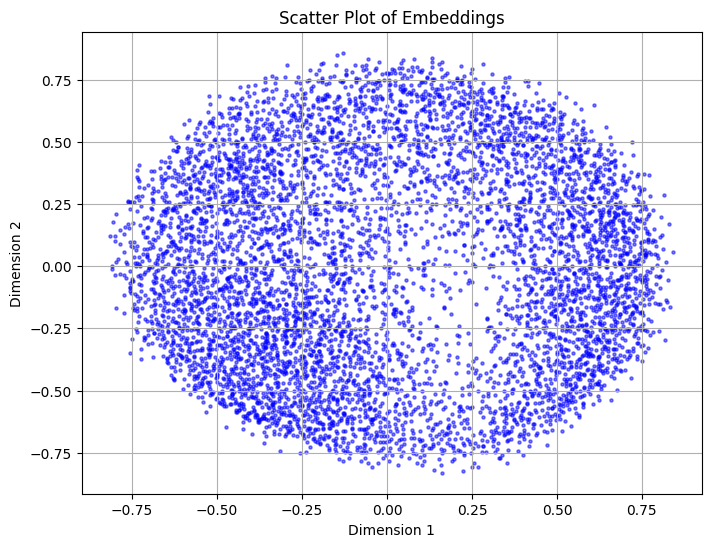

In [32]:
plot_embed(embeddings_2d_random)

In [83]:
embeddings_2d_special = embed_2d(train_ham_sampled)

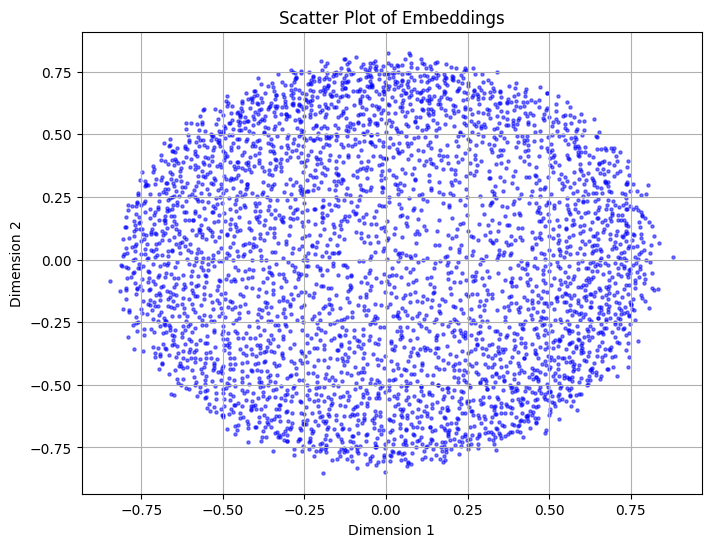

In [84]:
plot_embed(embeddings_2d_special)

### Load data

In [25]:
ds = load_data(path)
train_ds_r = ds['train_r']
train_ds_e = ds['train_e']
test_ds = ds['test']
val_ds = ds['validation']

Generating train_r split: 27712 examples [00:00, 442885.16 examples/s]
Generating train_e split: 15510 examples [00:00, 539627.01 examples/s]
Generating test split: 4035 examples [00:00, 462999.39 examples/s]
Generating validation split: 8190 examples [00:00, 412807.34 examples/s]


### Decoding of tokens and getting attention maps via BERT Tokenizer

In [26]:
def decode_and_tokenize_function(example):
    tokens = example['text']
    text = tokenizer.decode(tokens,skip_special_tokens=True)
    return tokenizer(text,padding=True)

In [27]:
tokenized_train_ds_r = train_ds_r.map(decode_and_tokenize_function)
tokenized_train_ds_e = train_ds_e.map(decode_and_tokenize_function)
tokenized_test_ds = test_ds.map(decode_and_tokenize_function)
tokenized_val_ds = val_ds.map(decode_and_tokenize_function)

Map: 100%|██████████| 8190/8190 [00:16<00:00, 507.10 examples/s]


In [28]:
tokenized_train_ds_r.save_to_disk(path+'/tokenized/train_ds_r')
tokenized_train_ds_e.save_to_disk(path+'/tokenized/train_ds_e')
tokenized_val_ds.save_to_disk(path+'/tokenized/val_ds')
tokenized_test_ds.save_to_disk(path+'/tokenized/test_ds')

Saving the dataset (1/1 shards): 100%|██████████| 4035/4035 [00:00<00:00, 250618.50 examples/s]
